# Preliminary Experiments with Existing Algorithms Part 3: Post-Processing algorithm- Calibrated Equalized Odds

In [1]:
import sys
import numpy as np
import pandas as pd

sys.path.append("../")
from aif360.datasets import AdultDataset, GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing

from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore')

In [2]:
#Import datasets

#Adult
adult_orig = load_preproc_data_adult()

a_privileged_groups = [{'sex': 1}]
a_unprivileged_groups = [{'sex': 0}]

adult_orig_train, adult_orig_test = adult_orig.split([0.7], shuffle=True)

#German
german_orig = load_preproc_data_german()

for i in range(1000):
    if (german_orig.labels[i] == 2.0):
        german_orig.labels[i] = 0
    else:
        german_orig.labels[i] = 1
        
german_orig.favorable_label = 1
german_orig.unfavorable_label = 0

g_privileged_groups = [{'age': 1}]
g_unprivileged_groups = [{'age': 0}]

german_orig_train, german_orig_test = german_orig.split([0.7], shuffle=True)

In [3]:
#Scaling the datasets
std_scaler = StandardScaler()
#German
X_train_g = std_scaler.fit_transform(german_orig_train.features)
X_test_g = std_scaler.transform(german_orig_test.features)

y_train_g = german_orig_train.labels.ravel()
y_test_g = german_orig_test.labels.ravel()

#Adult
X_train_a = std_scaler.fit_transform(adult_orig_train.features)
X_test_a = std_scaler.transform(adult_orig_test.features)

y_train_a = adult_orig_train.labels.ravel()
y_test_a = adult_orig_test.labels.ravel()

In [4]:
#Train Logistic Regression algorithm

#Logistic Regression Training for each dataset
log_reg_g = LogisticRegression() 
log_reg_a = LogisticRegression() 

#Fitting the German dataset
log_reg_g.fit(X_train_g, y_train_g)

#Fitting Adult dataset
log_reg_a.fit(X_train_a, y_train_a)


#Training data labels predictions
#German
fav_idx_g = np.where(log_reg_g.classes_ == german_orig_train.favorable_label)[0][0]
y_train_pred_proba_g = log_reg_g.predict_proba(X_train_g)[:,fav_idx_g]

#Adult
fav_idx_a = np.where(log_reg_a.classes_ == adult_orig_train.favorable_label)[0][0]
y_train_pred_proba_a = log_reg_a.predict_proba(X_train_a)[:,fav_idx_a]


#Predicting test set labels
#German
y_test_pred_g = log_reg_g.predict(X_test_g)
y_test_pred_proba_g = log_reg_g.predict_proba(X_test_g)[:,fav_idx_g]

#Adult
y_test_pred_a = log_reg_a.predict(X_test_a)
y_test_pred_proba_a = log_reg_a.predict_proba(X_test_a)[:,fav_idx_g]


#re-creating the test sets with predicted class labels
pred_adult_test = adult_orig_test.copy()
pred_adult_test.labels = y_test_pred_a

pred_german_test = german_orig_test.copy()
pred_german_test.labels = y_test_pred_g

In [5]:
'''# Prediction probs for validation and testing data: finding labels from the predicted probabilities
class_thresh = 0.5
#Adult
adult_orig_train.scores = y_train_pred_proba_a.reshape(-1,1)
adult_orig_test.scores = y_test_pred_proba_a.reshape(-1,1)

y_train_pred_a = np.zeros_like(adult_orig_train.labels)
y_train_pred_a[y_train_pred_proba_a >= class_thresh] = adult_orig_train.favorable_label
y_train_pred_a[~(y_train_pred_proba_a >= class_thresh)] = adult_orig_train.unfavorable_label
adult_orig_train.labels = y_train_pred_a
 
y_test_pred_a = np.zeros_like(adult_orig_test.labels)
y_test_pred_a[y_test_pred_proba_a >= class_thresh] = adult_orig_test.favorable_label
y_test_pred_a[~(y_test_pred_proba_a >= class_thresh)] = adult_orig_test.unfavorable_label
adult_orig_test.labels = y_test_pred_a


#German
german_orig_train.scores = y_train_pred_proba_g.reshape(-1,1)
german_orig_test.scores = y_test_pred_proba_g.reshape(-1,1)

y_train_pred_g = np.zeros_like(german_orig_train.labels)
y_train_pred_g[y_train_pred_proba_g >= class_thresh] = german_orig_train.favorable_label
y_train_pred_g[~(y_train_pred_proba_g >= class_thresh)] = german_orig_train.unfavorable_label
german_orig_train.labels = y_train_pred_g
 
y_test_pred_g = np.zeros_like(german_orig_test.labels)
y_test_pred_g[y_test_pred_proba_g >= class_thresh] = german_orig_test.favorable_label
y_test_pred_g[~(y_test_pred_proba_g >= class_thresh)] = german_orig_test.unfavorable_label
german_orig_test.labels = y_test_pred_g
'''

'# Prediction probs for validation and testing data: finding labels from the predicted probabilities\nclass_thresh = 0.5\n#Adult\nadult_orig_train.scores = y_train_pred_proba_a.reshape(-1,1)\nadult_orig_test.scores = y_test_pred_proba_a.reshape(-1,1)\n\ny_train_pred_a = np.zeros_like(adult_orig_train.labels)\ny_train_pred_a[y_train_pred_proba_a >= class_thresh] = adult_orig_train.favorable_label\ny_train_pred_a[~(y_train_pred_proba_a >= class_thresh)] = adult_orig_train.unfavorable_label\nadult_orig_train.labels = y_train_pred_a\n \ny_test_pred_a = np.zeros_like(adult_orig_test.labels)\ny_test_pred_a[y_test_pred_proba_a >= class_thresh] = adult_orig_test.favorable_label\ny_test_pred_a[~(y_test_pred_proba_a >= class_thresh)] = adult_orig_test.unfavorable_label\nadult_orig_test.labels = y_test_pred_a\n\n\n#German\ngerman_orig_train.scores = y_train_pred_proba_g.reshape(-1,1)\ngerman_orig_test.scores = y_test_pred_proba_g.reshape(-1,1)\n\ny_train_pred_g = np.zeros_like(german_orig_train.l

In [6]:
y_test_pred_proba_a

array([0.40537995, 0.35160492, 0.2146336 , ..., 0.29868146, 0.2146336 ,
       0.30107059])

In [7]:
# Learn parameters to equalize odds and apply to create a new dataset

# cost constraint of fnr will optimize generalized false negative rates, that of
# fpr will optimize generalized false positive rates, and weighted will optimize
# a weighted combination of both
cost_constraint = "weighted" # "fnr", "fpr", "weighted"

#random seed for calibrated equal odds prediction
randseed = 12345679

#Adult
ceopp_a = CalibratedEqOddsPostprocessing(privileged_groups = a_privileged_groups,
                                     unprivileged_groups = a_unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
ceopp_a = ceopp_a.fit(adult_orig_test, pred_adult_test)

#German
# Learn parameters to equalize odds and apply to create a new dataset
ceopp_g = CalibratedEqOddsPostprocessing(privileged_groups = g_privileged_groups,
                                     unprivileged_groups = g_unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
ceopp_g = ceopp_g.fit(german_orig_test, pred_german_test)

In [8]:
#new prediction of ceopp algorithm
#Adult
adult_transf_test_pred = ceopp_a.predict(pred_adult_test)
#German
german_transf_test_pred = ceopp_g.predict(pred_german_test)

### Results after post-processing

In [9]:
#Performance Metrics from Adult dataset post-processing predictions

metric_adult_eo_test = BinaryLabelDatasetMetric(pred_adult_test, 
                                             unprivileged_groups=a_unprivileged_groups,
                                             privileged_groups=a_privileged_groups)



classified_adult_eo_test = ClassificationMetric(adult_orig_test, 
                                                 pred_adult_test,
                                                 unprivileged_groups=a_unprivileged_groups,
                                                 privileged_groups=a_privileged_groups)


display(Markdown("#### Post-processed LR with Adult Test Set Fairness Performance (based on predictions)"))

#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
eop_aeo_a = classified_adult_eo_test.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % eop_aeo_a)

#Disparate Impact ratio between privileged and unprivileged groups.
eop_di_a = classified_adult_eo_test.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % eop_di_a)

#Demographic parity difference between privileged and unprivileged groups.
eop_spd_a = classified_adult_eo_test.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % eop_spd_a)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
eop_ppd_a = classified_adult_eo_test.positive_predictive_value(privileged=False) - classified_adult_eo_test.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % eop_ppd_a)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_adult_eo_test.consistency())


#Prediction performance metrics
TPRa = classified_adult_eo_test.true_positive_rate() #recall
TNRa = classified_adult_eo_test.true_negative_rate() #specificity
PPVa = classified_adult_eo_test.positive_predictive_value() #precision
bal_acc_a = (TPRa+TNRa)/2
f1_a = 2*((PPVa*TPRa)/(PPVa+TPRa))

display(Markdown("#### Post-processed LR with Adult Test Set Prediction Performance"))
print("Standard accuracy of logistic regression trained on German dataset without any mitigation = %f" % classified_adult_eo_test.accuracy())
print("Balanced accuracy of logistic regression trained on German dataset without any mitigation = %f" % bal_acc_a)
print("F1 score of logistic regression trained on German dataset without any mitigation = %f" % f1_a)

print("Detailed scores for Adult dataset")
print("Precision (PPV): %f" %PPVa)
print("Recall (TPR): %f" %TPRa)
print("Specificity (TNR): %f" %TNRa)
print("F1-score: %f" %f1_a)


#### Post-processed LR with Adult Test Set Fairness Performance (based on predictions)

Average equalized odds difference between unprivileged and privileged groups = -0.280132
Disparate impact ratio between unprivileged and privileged groups = 0.000000
Demographic parity difference between unprivileged and privileged groups = -0.211454
Predictive Parity difference between unprivileged and privileged groups = -0.646802
Consistency of indivuals' predicted labels = 1.000000


#### Post-processed LR with Adult Test Set Prediction Performance

Standard accuracy of logistic regression trained on German dataset without any mitigation = 0.805432
Balanced accuracy of logistic regression trained on German dataset without any mitigation = 0.660530
F1 score of logistic regression trained on German dataset without any mitigation = 0.483608
Detailed scores for Adult dataset
Precision (PPV): 0.646802
Recall (TPR): 0.386173
Specificity (TNR): 0.934887
F1-score: 0.483608


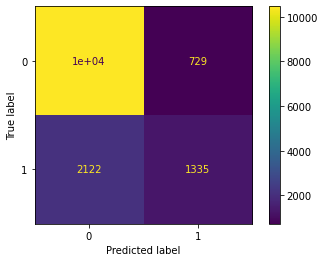

In [10]:
cm_adult = confusion_matrix(adult_orig_test.labels, pred_adult_test.labels)

disp_adult = ConfusionMatrixDisplay(confusion_matrix=cm_adult)
disp_adult.plot()

In [12]:
#Performance Metrics from German dataset post-processing predictions

metric_german_eo_test = BinaryLabelDatasetMetric(pred_german_test, 
                                             unprivileged_groups=g_unprivileged_groups,
                                             privileged_groups=g_privileged_groups)



classified_german_eo_test = ClassificationMetric(german_orig_test, 
                                                 pred_german_test,
                                                 unprivileged_groups=g_unprivileged_groups,
                                                 privileged_groups=g_privileged_groups)


display(Markdown("#### Post-processed LR with German Test Set Fairness Performance (based on predictions)"))

#Checking Equalized Odds: average odds differecence, which is the avg. of differences in FPR&TPR for privileged and unprivileged groups.
eop_aeo_g = classified_german_eo_test.average_odds_difference()
print("Average equalized odds difference between unprivileged and privileged groups = %f" % eop_aeo_g)

#Disparate Impact ratio between privileged and unprivileged groups.
eop_di_g = classified_german_eo_test.disparate_impact()
print("Disparate impact ratio between unprivileged and privileged groups = %f" % eop_di_g)

#Demographic parity difference between privileged and unprivileged groups.
eop_spd_g = classified_german_eo_test.statistical_parity_difference()
print("Demographic parity difference between unprivileged and privileged groups = %f" % eop_spd_g)

#Predictive parity difference: PPV difference between privileged and unprivileged groups.
eop_ppd_g = classified_german_eo_test.positive_predictive_value(privileged=False) - classified_german_eo_test.positive_predictive_value(privileged=True)
print("Predictive Parity difference between unprivileged and privileged groups = %f" % eop_ppd_g)

#Individual Fairness: 1)Consistency, 2) Euclidean Distance between individuals.
print("Consistency of indivuals' predicted labels = %f" % metric_german_eo_test.consistency())


#Prediction performance metrics
TPRg = classified_german_eo_test.true_positive_rate() #recall
TNRg = classified_german_eo_test.true_negative_rate() #specificity
PPVg = classified_german_eo_test.positive_predictive_value() #precision
bal_acc_g = (TPRg+TNRg)/2
f1_g = 2*((PPVg*TPRg)/(PPVg+TPRg))

display(Markdown("#### Post-processed LR with German Test Set Prediction Performance"))
print("Standard accuracy of logistic regression trained on German dataset without any mitigation = %f" % classified_german_eo_test.accuracy())
print("Balanced accuracy of logistic regression trained on German dataset without any mitigation = %f" % bal_acc_g)
print("F1 score of logistic regression trained on German dataset without any mitigation = %f" % f1_g)

print("Detailed scores for german dataset")
print("Precision (PPV): %f" %PPVg)
print("Recall (TPR): %f" %TPRg)
print("Specificity (TNR): %f" %TNRg)
print("F1-score: %f" %f1_g)

#### Post-processed LR with German Test Set Fairness Performance (based on predictions)

Average equalized odds difference between unprivileged and privileged groups = -0.461874
Disparate impact ratio between unprivileged and privileged groups = 0.557377
Demographic parity difference between unprivileged and privileged groups = -0.442623
Predictive Parity difference between unprivileged and privileged groups = 0.015506
Consistency of indivuals' predicted labels = 0.989333


#### Post-processed LR with German Test Set Prediction Performance

Standard accuracy of logistic regression trained on German dataset without any mitigation = 0.686667
Balanced accuracy of logistic regression trained on German dataset without any mitigation = 0.559033
F1 score of logistic regression trained on German dataset without any mitigation = 0.800847
Detailed scores for german dataset
Precision (PPV): 0.692308
Recall (TPR): 0.949749
Specificity (TNR): 0.168317
F1-score: 0.800847


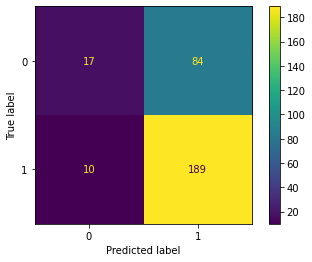

In [13]:
cm_german = confusion_matrix(german_orig_test.labels, pred_german_test.labels)

disp_german = ConfusionMatrixDisplay(confusion_matrix=cm_german)
disp_german.plot()